# **Maestría en Inteligencia Artificial Aplicada**

## **Inteligencia Artificial y Aprendizaje Automático**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## **Modelos sobre datos de Series de Tiempo: Ingenuo / SARIMA / Prophet / LSTM**


#### **Los diferentes modelos que aplicamos en este ejercicio son utilizando la base de datos que nos muestran el total de pasajeros mensuales que viajaron en una aerolínea de EEUU de 1949 a 1960.**

#### **La liga de los datos la puedes encontrar en la siguiente liga de Kaggle:**

https://www.kaggle.com/datasets/chirag19/air-passengers



# **0 - Preparando los datos**

In [1]:
# Omitamos los Warnings por el momento:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!pip freeze   # Si deseas verificar qué librerías y versiones ya tiene google-Colab preinstaladas,
               # en particular "prophet" que usaremos en este ejercicio.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import mean_squared_error
import math

from prophet import Prophet
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf   # gráficos de autocorrelación

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/IAAyAA/Semana9/monthly_champagne_sales.csv'
df = pd.read_csv(path, header=0)
df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [5]:
df.info()   # Observamos que la fecha es por el momento una variable de tipo objeto o categórica.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   105 non-null    object
 1   Sales   105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [6]:
# Renombremos de manera estándar las columnas de fechas y valores de la
# serie de tiempo, donde además la fecha la trasnformamos a tipo datetime:

df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

df.head()

,ds,y
0,1964-01-01,2815
1,1964-02-01,2672
2,1964-03-01,2755
3,1964-04-01,2721
4,1964-05-01,2946


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      105 non-null    datetime64[ns]
 1   y       105 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


En particular datetime64[ns] nos ayuda a representar un rango de fechas muy amplio (del año 1678 al 2262) con precisión de nanosegundos.

### **Agreguemos los ajustes usuales en Series de tiempo:**

In [8]:
# Hagamos una copia del DataFrame df con índices temporales:
df_temp = df.copy()
df_temp.set_index('ds', inplace=True)
df_temp

,y
ds,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


In [9]:
print(df.shape)
print(df_temp.shape)

(105, 2)
(105, 1)


https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.html

In [10]:
# Ajustemos la frecuencia de los índices, para que el modelo tenga información del período en que
# se encuentran los datos:

df_temp.index  # Observamos que aquí todavía no se tiene información del argumento "freq"

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='ds', length=105, freq=None)

Para las opciones de "freq" ver la tabla que viene en esta liga:

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [11]:
# Especifiquemos entonces que nuestros datos están registrados con una frecuencia mensual
# al inicio del mes (cada día 01 de cada mes):
df_temp.index.freq = 'MS'  # MS-Month-start-frequency o M=ME-Month-end-frequency

df_temp.index

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01', '1964-06-01', '1964-07-01', '1964-08-01',
               '1964-09-01', '1964-10-01',
               ...
               '1971-12-01', '1972-01-01', '1972-02-01', '1972-03-01',
               '1972-04-01', '1972-05-01', '1972-06-01', '1972-07-01',
               '1972-08-01', '1972-09-01'],
              dtype='datetime64[ns]', name='ds', length=105, freq='MS')

In [12]:
# Particionemos en entrenamiento y prueba como DataFrames de Pandas:

train = df_temp.iloc[0:-12,:]

test = df_temp.iloc[-12:,:]   # Seleccionamos los datos del último año para predicción de Test.

In [13]:
train.shape

(93, 1)

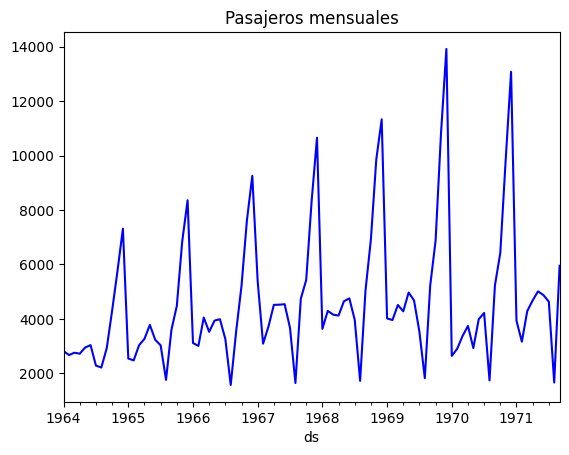

In [14]:
# Gráfico con la periodicidad mensual:
train['y'].plot(title='Pasajeros mensuales', style='-b')
plt.show()

De este gráfico podemos observar:

1.    Que tenemos una tendencia creciente, con una estacionalidad anual muy marcada

2.   Que el modelo multiplicativo de la serie de tiempo se adaptaría mejor a uno aditivo, ya que la amplitud de la variabilidad se observa que va en aumento.



# **1 - Modelo ingenuo (Baseline / Persistance / Naive model)**

*   El modelo ingenuo simplemente hace la predicción del siguiente perídodo, repitiendo el valor del último período.

*   Este modelo se utiliza en general como punto de partida para comparar todos los demás,

*   Utilicemos el error RMSE (Raíz del Error Cuadrático Medio) como medida del desempeño de nuestros modelos a obtener.

In [15]:
test['y'].values

array([ 6981,  9851, 12670,  4348,  3564,  4577,  4788,  4618,  5312,
        4298,  1413,  5877])

In [16]:
history = [x for x in train['y'].values]   # Definimos "history" donde de manera incremental se irán agregando registros mensuales.
predictions = list()    # Lista que contendrá las predicciones del modelo ingenuo.

for i in range(len(test['y'])):
  # Obtenemos las predicciones:
  yhat = history[-1]   # La primera vez, tomamos el último dato del Train, en las siguientes, se van agregando los datos de Test.
  predictions.append(yhat)

  # Observaciones-registros reales:
  obs = test.iloc[i]['y']   # Ahora vamos tomando los datos de Test.
  history.append(obs)  # Vamos agregando a "history" (que ya tiene todo los de Train) en cada iteración, un dato más de los de Test.
  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))


# Calculamos la raíz del error cuadrático medio (RMSE):
rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
print('\nError-Modelo-Naive: RMSE: %.3f' % rmse)

>Esperado-real = 6981, Predicción = 5951.000
>Esperado-real = 9851, Predicción = 6981.000
>Esperado-real = 12670, Predicción = 9851.000
>Esperado-real = 4348, Predicción = 12670.000
>Esperado-real = 3564, Predicción = 4348.000
>Esperado-real = 4577, Predicción = 3564.000
>Esperado-real = 4788, Predicción = 4577.000
>Esperado-real = 4618, Predicción = 4788.000
>Esperado-real = 5312, Predicción = 4618.000
>Esperado-real = 4298, Predicción = 5312.000
>Esperado-real = 1413, Predicción = 4298.000
>Esperado-real = 5877, Predicción = 1413.000

Error-Modelo-Naive: RMSE: 3135.480


#### **Este valor de predicción RMSE nos dice que en promedio el error es de aproximadamente más menos 53 pasajeros por cada predicción hecha. Este será nuestro error RMSE a mejorar.**

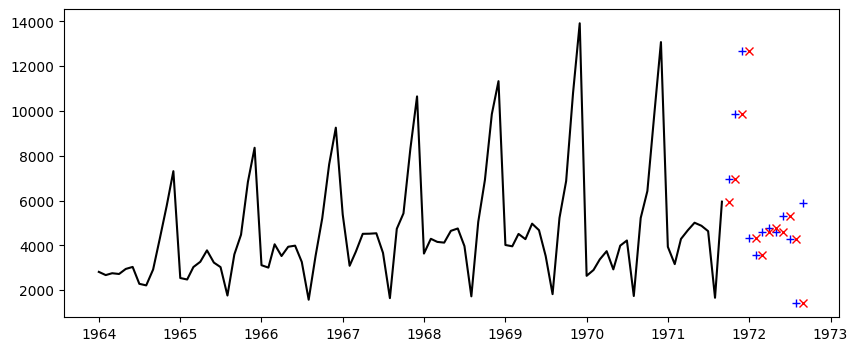

In [17]:
# Grafiquemos los resultados:

fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['y'], '-k')  # Datos de entrenamiento de 1949 a 1959 (los históricos).
ax = plt.plot(test['y'], '+b')    # Datos de prueba reales del año 1960 (los del útimo año a predecir).
ax = plt.plot(test.index, predictions, 'xr')  # Predicciones del modelo ingenuo para el último año 1960.

#### **Aunque pareciera que las predicciones fueron bastante exactas en el gráfico, en realidad están todas desfasadas un año.**

# **2 - Modelo ARIMA**

### **Análisis preliminar para obtener información de la serie de tiempo y construir el modelo ARIMA(p,d,q).**

*   **AR (AutoRegresivo):** El modelo se basa en la relación entre un valor actual y sus valores pasados.

*   **I (Integrado):** Se refiere a la diferenciación de la serie para hacerla estacionaria, es decir, eliminar tendencias y patrones cíclicos.

*   **MA (Media Móvil):** Usa el error de los valores pasados (las desviaciones entre valores predichos y observados) para corregir el valor actual.

##### **Ahora veamos el gráfico de descomposición de la serie de tiempo en sus componentes de tendencia (trend), estacionalidad (stationality) y residual (residual).**

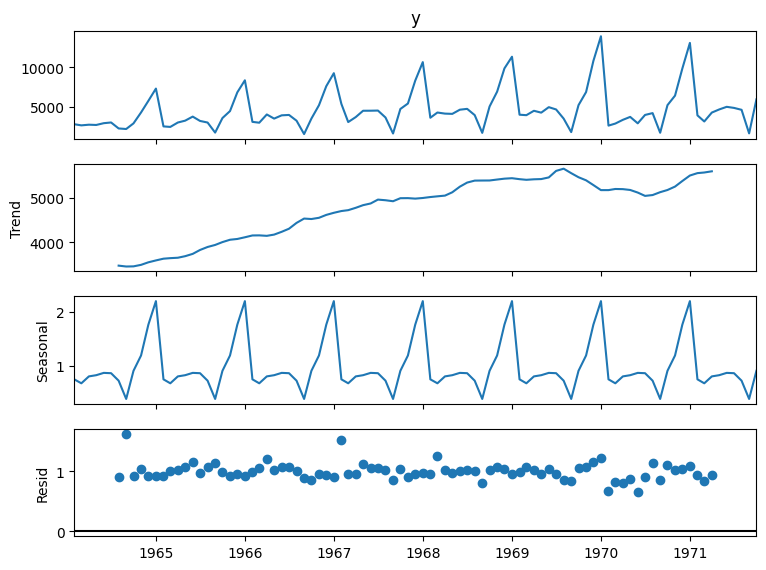

In [18]:
# Gráficos de descomposición estacional:
decomposition = seasonal_decompose(train['y'].resample('M').mean(), model='multiplicative')  # <<<---- Observa que el modelo es multiplicativo
fig = decomposition.plot()
fig.set_size_inches(8,6)
plt.show()

**Observa del gráfico de Residuos que estos están alrededor del 1, a diferencia del aditivo que usualmente están alrededor del 0.**

##### **Veamos ahora estos dos gráficos que nos hablan si tenemos algún tipo de estacionalidad (i.e., periodicidad). En particular, mensual o trimestral:**

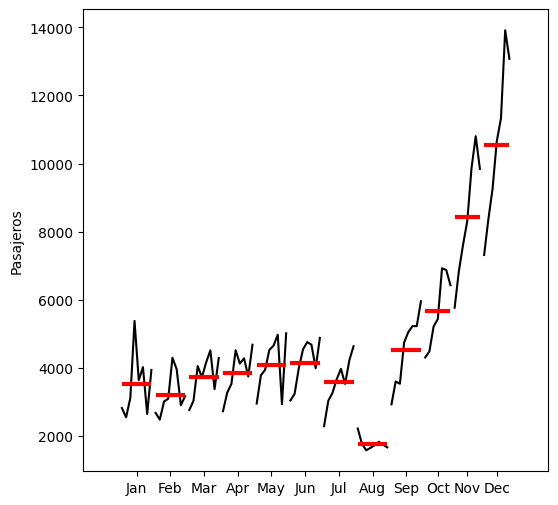

In [19]:
# Gráfica para detección de estacionalidad mensual:
fig = month_plot(train['y'].resample('M').mean(), ylabel='Pasajeros')
fig.set_size_inches(6,6)
plt.show()

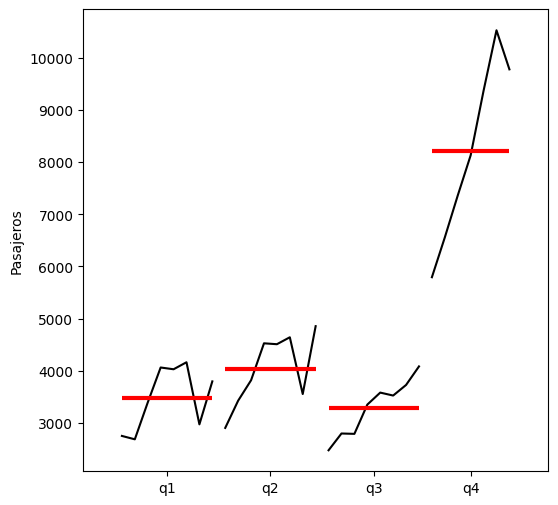

In [20]:
# Si queremos graficar y detectar estacionalidad trimestral:
fig = quarter_plot(train['y'].resample('Q').mean(), ylabel='Pasajeros')
fig.set_size_inches(6,6)
plt.show()

### **Gráficos de Autocorrelación (ACF) y Autocorrelación Parcial (PACF)**

*   Los gráficos de Autocorrelación miden la correlación entre la serie de tiempo y una versión rezagada de sí misma.

*   Este tipo de correlaciones de una serie de tiempo consigo misma son llamadas "autocorrelaciones" o "correlaciones seriales".

*   En el eje horizontal se muestra el valor del desfazamiento (lag) y en el eje vertical el valor de correlación de la serie desfazada y la original.

*   El cono sombreado indica intervalos de confianza de la correlación, con un 95% de confianza de manera predeterminada.

*   Que existan autocorrelaciones significativas en estos gráficos nos habla de que la serie de tiempo no es aleatoria.

*   En estos dos gráficos (llamados en inglés "pollipop plots") hay que determinar cuántos de estos lollipops están afuera del intervalo de confianza (sin contar el inicial) antes de que entre el siguiente a la zona celeste?

*   **Gráfico ACF:** Muestra la correlación total entre la serie y sus retardos, incluyendo efectos directos e indirectos.

*   **Gráfico PACF:** Muestra la correlación directa entre la serie y sus retardos, eliminando los efectos de los retardos intermedios.

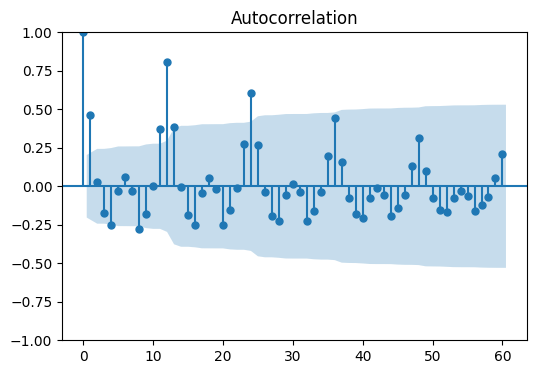

In [21]:
# Gráfico de Autocorrelación (ACF: Auto-Correlation-Function)
fig,ax = plt.subplots(figsize = (6,4))
plot_acf(train['y'], lags=60, ax=ax)   # Eliges el número de unidades (meses) desfasadas. El número de "lags" es el número
plt.show()                          # que define la partición en el eje horizontal. El área no sombreada nos habla de
                                    # la cantidad de períodos de tiempo hacia atrás cuya información proporcionada es
                                    # significativa para la predicción futura.
                                    # También nos ayuda a detectar periodicidades, como en este caso que se observa a 13 meses, aprox.

El gráfico inicia con desfase (lag) de 0, lo cual es la correlación de la serie de tiempo consigo misma, la cual es 1.

Posteriormente se muestran las correlaciones de la serie de tiempo original, con la serie desfasada "q" lugares hacia atrás, es decir, de orden "q" en la componente MA de ARIMA(p,d,q).

**El gráfico ACF nos dice en primera instancia que la componente MA de ARIMA(p,d,q) tiene un grado "q" de 13 (en la práctica se puede buscar de 0 a 13).**

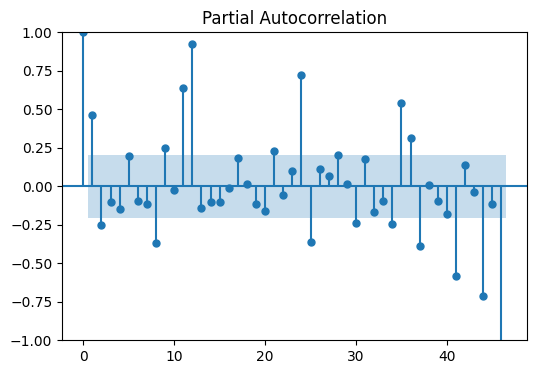

In [23]:
# Gráfico de Autocorrelación Parcial (PACF):
fig, ax = plt.subplots(figsize = (6,4))
plot_pacf(train['y'], lags = 46, ax = ax, method="ols")   # ols: regression of time series on lags of it an on constant. predetrminado method="ywm"
plt.show()

* PACF también inicia con la correlación de la serie de tiempo consigo misma, por ello el valor de 1.

*   **De este gráfico podemos observar que la componente AR de ARIMA(p,d,q) tiene grado p=3 o tal vez 5 (en la práctica se puede probar de 0 a 5.)**

##### Existe un buen número de librerías para el caso de pronósticos con los modelos ARIMA-SARIMA. Usaremos en este ejercicio la de Statsmodels, cuya documentación encuentras en la siguiente liga:

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html

In [24]:
from statsmodels.tsa.arima.model import ARIMA

In [25]:
# Lo primero es para quitar la estacionalidad y transformar un problema
# de tipo no-estacionario (SARIMA) en uno estacionario (ARIMA):

# Diferencia de datos consecutivos en el tiempo
# y podemos ahora usar ARIMA:
def difference(dataset, interval=1):
  diff = list()

  for i in range(interval, len(dataset)):
    value = dataset[i] - dataset[i - interval]
    diff.append(value)

  return np.array(diff)



# Invierte las diferencias anteriores, es decir, nos regresa la estacionalidad:
def inverse_difference(history, yhat, interval=1):
  return yhat + history[-interval]


In [26]:
# Definamos la siguiente lista de registros de pasajeros en el tiempo:
history = [x for x in train.loc[:,'y'].values]   # train-ndarray : columna solo con los registros de pasajeros "y".
                               # history-list : lista con los datos del train.

predictions = list()   # Para incluir las predicciones que vaya generando el modelo.

for i in range(len(test['y'])):
  #
  months_in_year = 12
  diff = difference(history, months_in_year)    # diff-list: lista de los datos de diferencias para transformar SARIMA en ARIMA.

  # Generamos el modelo.
  model = ARIMA(diff, order=(3,0,13),) # Si aplicamos diff, entonces d=0 es aplicable.
  model_fit = model.fit(method_kwargs={'maxiter':300})  # Aumentar las iteraciones para evitar el WarningConvergence.

  yhat = model_fit.forecast()[0]   # prediccions (yhat) de cada registro, es un solo número flotante.
  yhat = inverse_difference(history, yhat, months_in_year)    # El "history" sigue siendo la lista de arriba.
                                                              # El nuevo "yhat" es cada un nuevo valor (float) de predicción.
  predictions.append(yhat)  # predictions-list : lista que se va incrementando al ir agregando cada predicción nueva.

  # Observaciones-reales:
  obs = test.iloc[i]['y']   #  cada dato es un flotante.
  history.append(obs)   #  history-list : se va incrementado a partir del Train con los registros-observaciones reales.

  print('>Esperado-real = %3d, Predicción = %.3f' % (obs, yhat))

# Error RMSE:
rmse = np.sqrt(mean_squared_error(test['y'].values, predictions))
print('\nError-Modelo-ARIMA: RMSE: %.3f' % rmse)

>Esperado-real = 6981, Predicción = 6726.531
>Esperado-real = 9851, Predicción = 9898.715
>Esperado-real = 12670, Predicción = 13641.247
>Esperado-real = 4348, Predicción = 4083.349
>Esperado-real = 3564, Predicción = 3728.547
>Esperado-real = 4577, Predicción = 4256.122
>Esperado-real = 4788, Predicción = 5060.375
>Esperado-real = 4618, Predicción = 5300.950
>Esperado-real = 5312, Predicción = 5045.039
>Esperado-real = 4298, Predicción = 4981.132
>Esperado-real = 1413, Predicción = 1692.169
>Esperado-real = 5877, Predicción = 5846.067

Error-Modelo-ARIMA: RMSE: 444.210


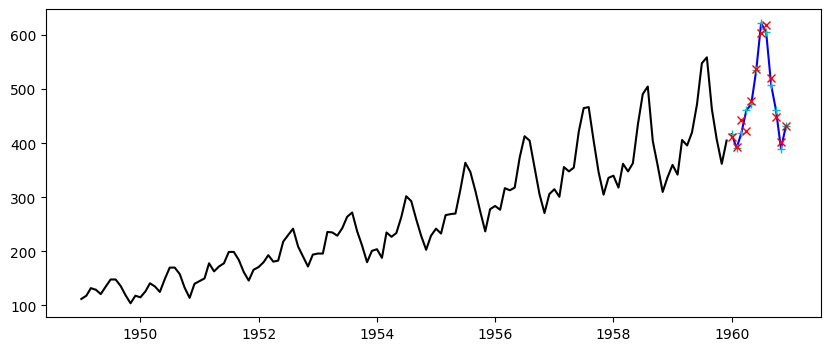

In [ ]:
# Veamos su gráfico:
fig, ax = plt.subplots(figsize=(10, 4))
ax = plt.plot(train['y'], '-k')
ax = plt.plot(test['y'], '-b')
ax = plt.plot(test['y'], '+c')
ax = plt.plot(test.index, predictions, 'xr')

# **3 - Modelo Facebook-Meta-Prophet**

#### **En la liga del modelo Facebook-Prophet puedes encontrar mucho más información, además de la documentación correspondiente:**

https://facebook.github.io/prophet/

In [ ]:
# Prophet requiere que la entrada sean dos columnas, llamadas "ds" y "y".
# Les dmos esta forma usando el DataFrame "df" inicial:

train = df.iloc[0:-12,:]
test = df.iloc[-12:,:]

In [ ]:
# Aplicamos el modelo Facebbok-Prophet a nuestros datos:

model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=True,
                changepoint_prior_scale=10.,   # Controla la flexibilidad de la componente Trend, mayor valor mayores fluctuaciones.
                seasonality_prior_scale=18)    # Controla la estacionalidad, mayor el valor, mayor flexibilidad en la estacionalidad.
model.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdo8c8v42/tm4jbwzw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdo8c8v42/dda6dav1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=236', 'data', 'file=/tmp/tmpdo8c8v42/tm4jbwzw.json', 'init=/tmp/tmpdo8c8v42/dda6dav1.json', 'output', 'file=/tmp/tmpdo8c8v42/prophet_modelvao4kstz/prophet_model-20241104071030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:10:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:10:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Calculamos el error RMSE:

pred_FP = model.predict(test)['yhat']
rmse = np.sqrt(mean_squared_error(test['y'], pred_FP))
print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % rmse)


Error-Modelo-FacebookProphet: RMSE: 21.928


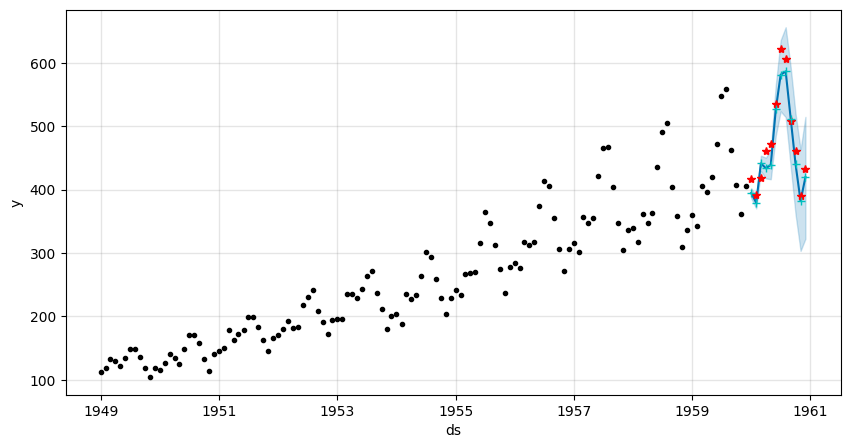

In [ ]:
# La librería misma nos permite obtener las predicciones con las cotas mínima
# y máxima, además de su gráfica, como se muestra a continuación:

forecast = model.predict(test)

fig, ax = plt.subplots(figsize=(10, 5))
model.plot(forecast, ax=ax)               # Las predicciones se muestran con la línea continua, junto con su región de variabilidad de la predicción.
ax = plt.plot(test['ds'], test['y'], '*r')   # Agregamos los datos de prueba (Test) con puntos rojos, para observar la diferencia.
ax = plt.plot(test['ds'], forecast['yhat'], '+c')    # Valores reales.


**Observamos que es algo conservador en sus predicciones, ya que se queda algo corto con las predicciones más altas y ligeramente por arriba de las predicciones más bajas.**

# **4 - Long Short Term Memory (LSTM)**

In [ ]:
import tensorflow as tf

In [ ]:
def preparando_datos(myData, myDate):

  # ++++++++ TRAIN +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  # Los datos de entrenamiento son previos a la fecha "Date" que indiques y
  # tomarán hisotriales en este caso de 12 períodos previos.
  Train_Data = myData['y'][myData['ds'] < myDate].to_numpy()

  periodo = 12   # 12 meses al año

  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []

  for i in range(0, len(Train_Data), periodo):    # observa que va formando el Train set con historiales de 12 períodos consecutivos.
    try:
      Data_Train.append(Train_Data[i : i + periodo])
    except:
      pass


  # En ocasiones hay datos perdidos, en cuyo caso la última serie
  # de datos la eliminamos:
  if len(Data_Train[-1]) < periodo:
    Data_Train.pop(-1)


  # Hay que darle la forma (dimensionalidad) que requieren los modelos
  # de aprendizaje profundo, en particular la librería de TensorFlow:
  #     (batch_size, sequence_length, input_dimension).

  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, periodo, 1))

  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, periodo, 1))


  # +++++++++++ TEST +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

  # Los datos de prueba (Test) son posteriores a la fecha "Date" y que es el
  # último ciclo que deseas predecir:
  Test_Data = myData['y'][myData['ds'] >= myDate].to_numpy()

  # inicialización de listas:
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []

  for i in range(0, len(Test_Data), periodo):
    try:
      Data_Test.append(Test_Data[i : i + periodo])
    except:
      pass


  if len(Data_Test[-1]) < periodo:
    Data_Test.pop(-1)

  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, periodo, 1))

  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, periodo, 1))


  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y


In [ ]:
# Continuemos con el DataFrame como en Prophet:

threshold_Date = '1959-01-01'   # A partir de esta fecha se empieza a generar el Test.
                                # En este caso, el Text_X serán los 12 meses de 1959
                                # y el Test_Y serán los de 1960.

# Recuerda que la columna de fechas del DataFrame df, debe ser de tipo DateTime.
# Se generan paquetes de 12 meses. Los *_Y son los años desfasados hacia adelante
# de los *_X:

Train_X, Train_Y, Test_X, Test_Y = preparando_datos(df, threshold_Date)

In [ ]:
# Podemos definir la manera en que el tamaño de paso (learning-rate) varíe
# en cada época. Es usual definir también algunas funciones, exponenciales,
# por ejemplo. Por el momento definamos valores constantes por intervalos:

def scheduler(epoch):

  if epoch <= 100:
    lrate = 0.05
  elif epoch <= 180:
    lrate = 0.0005
  elif epoch <=190:
    lrate = 0.00005
  else:
    lrate = (10 ** -5)

  return lrate


callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 75246.4062 - root_mean_squared_error: 274.3108 - val_loss: 11164357.0000 - val_root_mean_squared_error: 3341.3108 - learning_rate: 0.0500
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 72143.8828 - root_mean_squared_error: 268.5961 - val_loss: 35891720.0000 - val_root_mean_squared_error: 5990.9697 - learning_rate: 0.0500
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 62717.1719 - root_mean_squared_error: 250.4340 - val_loss: 781617088.0000 - val_root_mean_squared_error: 27957.4160 - learning_rate: 0.0500
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 33984.7500 - root_mean_squared_error: 184.3495 - val_loss: 1272603776.0000 - val_root_mean_squared_error: 35673.5742 - learning_rate: 0.0500
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 12037.1768 - root_mean_squared_error: 109.7141 - val_loss: 1008556096.0000 - val_root_mean_squared_error: 31757.7715 - learning_rate: 0.0500
Epoch 6/200
1

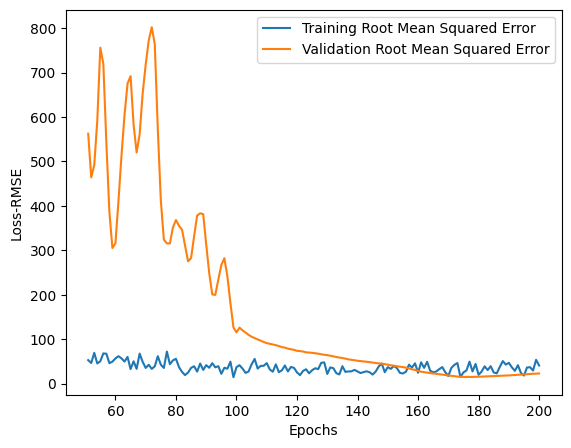

In [ ]:
def myModel():

  model = tf.keras.models.Sequential([tf.keras.layers.LSTM(20, input_shape=(12, 1), activation=tf.nn.leaky_relu, return_sequences=True),
                                      tf.keras.layers.BatchNormalization(),
                                      tf.keras.layers.Dropout(0.2),
                                      #tf.keras.layers.LSTM(20, activation=tf.nn.leaky_relu),
                                      #tf.keras.layers.BatchNormalization(),
                                      #tf.keras.layers.Dropout(0.2),

                                      tf.keras.layers.Dense(200, activation=tf.nn.leaky_relu),
                                      tf.keras.layers.Dropout(0.2),
                                      #tf.keras.layers.Dense(120, activation=tf.nn.leaky_relu),


                                      tf.keras.layers.Dense(12, activation=tf.nn.leaky_relu)
                                      ])
  return model


# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


my_LSTM_model2 = myModel()

my_LSTM_model2.compile(optimizer=tf.keras.optimizers.Adam(),
                      loss='mse',    # función de costo "mse"
                      metrics=[tf.keras.metrics.RootMeanSquaredError()]   #  RMSE- despliega
                      )


H = my_LSTM_model2.fit(Train_X,
                       Train_Y,
                       epochs=200,
                       validation_data=(Test_X, Test_Y),
                       callbacks=[callback],

                       )



N = 50  # Para omitir los N primeros valores en la gráfica, que en ocasiones son
        # demasiado grandes los errores y no dejan apreciar las curvas de aprendizaje.

epochs = range(N+1, len(H.history["loss"]) + 1)

fig, ax2 = plt.subplots()
fig.set_figheight(5)
ax2.plot(epochs, H.history["root_mean_squared_error"][N:], label = "Training Root Mean Squared Error")
ax2.plot(epochs, H.history["val_root_mean_squared_error"][N:], label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss-RMSE")
ax2.legend()

plt.show()

In [ ]:
# Calculamos el error RMSE:

#pred_LSTM = H.model.predict(Test_X)
pred_LSTM = my_LSTM_model2.predict(Test_X).reshape(-1)

rmse = np.sqrt(mean_squared_error(test['y'].values, pred_LSTM))

print('\nError-Modelo-FacebookProphet: RMSE: %.3f' % rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step

Error-Modelo-FacebookProphet: RMSE: 22.956


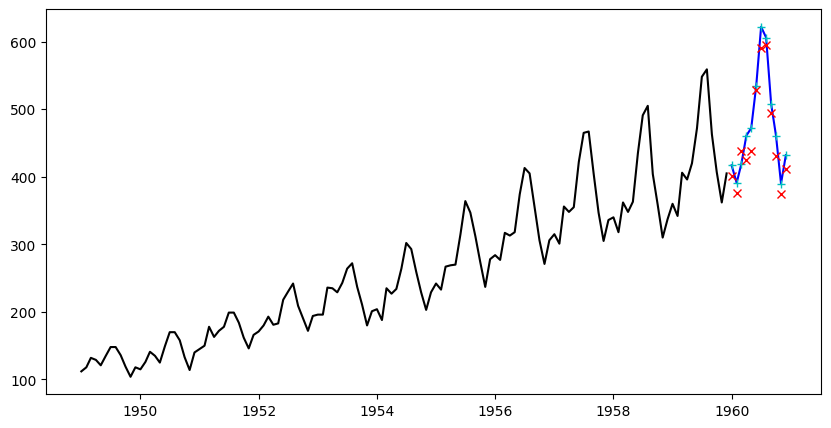

In [ ]:
# Graficamos los resultados:

# Grafiquemos los resultados:

fig, ax = plt.subplots(figsize=(10, 5))
ax = plt.plot(train['ds'], train['y'], '-k')  # Datos de entrenamiento de 1949 a 1959.
ax = plt.plot(test['ds'], test['y'], '-b')    # Datos de prueba del año 1960.
ax = plt.plot(test['ds'], test['y'], '+c')    # Datos de prueba del año 1960.
ax = plt.plot(test['ds'], pred_LSTM, 'xr')  # Predicciones del modelo del año 1960.

**Habría que buscar la mejor arquitectura y ejecutarlo varias veces para obtener un mejor resultado.**

>> ## **Fin del Ejercicio de Series de Tiempo**